# Importing Modules

In [1]:
from dataclasses import dataclass, asdict
from dataclass_csv import DataclassReader
from typing import Optional
from enum import Enum
import pandas as pd
import numpy as np
import json

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro
from scipy.stats import normaltest
import scipy.stats

from abc import abstractmethod

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import r2_score
from statsmodels.api import OLS
import statsmodels.api as sm
import pickle
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Reading the Data

In [2]:
class InfillPattern(Enum):
    GRID = "grid"
    HONEYCOMB = "honeycomb"

In [3]:
class Material(Enum):
    ABS = "abs"
    PLA = "pla"

In [4]:
@dataclass
class ThreeDPrinterData:
    layer_height: float
    wall_thickness: int
    infill_density: int
    infill_pattern: InfillPattern
    nozzle_temperature: int
    bed_temperature: int
    print_speed: int
    material: Material
    fan_speed: int
    roughness: int
    tensile_strength: int
    elongation: float

In [5]:
FILENAME = './3dprinterdata_edited.csv'

In [6]:
def readCSVData(flname):
    with open(flname) as data_csv:
        reader = DataclassReader(data_csv, ThreeDPrinterData)
        reader.map('Tensile Strength').to('tensile_strength')
        reader.map('Elongation').to('elongation')
        data_objects = []
        for row in reader:
            data_objects.append(row)
    
    df = pd.DataFrame(data_objects)
    df['infill_pattern'] = df['infill_pattern'].map(lambda obj: obj.value)
    df['material'] = df['material'].map(lambda obj: obj.value)
    
    return df, df.columns

In [7]:
df, df_columns = readCSVData(FILENAME)

# Step - 1 : Exploratory Data Analysis

In [8]:
class GeneralStatistics:
    def __init__(self, data):
        self.data = data
        self.cor = self.data.corr()
        self.cat_features = ['infill_pattern', 'material']
        
    def counts(self):
        print("There are {} datapoints and {} features".format(self.data.shape[0], self.data.shape[1]))
        
    def isNull(self):
        total = sum(self.data.isnull().sum())
        print("There are {} null values in the dataset".format(total))
        
    def descriptiveStats(self):
        print("\nThis is the mean value of all the variables\n\n")
        return self.data.describe().T['mean']
    
    def pairwiseCorrelation(self):
        plt.figure(figsize = (12, 12))
        sns.heatmap(self.cor, cbar = True, annot = True, cmap = 'Blues')
        
    def correlatedFeatures(self, target, positive = 0.4, negative = -0.1):
        cor_target = self.cor[target]
        
        positive_cor_features = cor_target[cor_target >= positive]
        pos_corr = [(feature, value) for feature, value in zip(positive_cor_features.index, positive_cor_features.values) if feature not in target]
        
        negative_cor_features = cor_target[cor_target <= negative]
        neg_corr = [(feature, value) for feature, value in zip(negative_cor_features.index, negative_cor_features.values) if feature not in target]
        
        return {'target': target, 
                'postive_cor': pos_corr, 
                'negative_cor': neg_corr}
    
    def targetRelation(self, corr_stats):
        features = []
        out = {}
        for k, v in corr_stats.items():
            if k == 'target':
                target_var = v
            else:
                for (feature, score) in v:
                    features.append(feature)
        out = {'target': target_var, 'features': features}
        
        for feature in features:
            self.scatterPlot(feature, out['target'], self.data)
    
    def plotCategorical(self, x, y):
        if x in self.cat_features:
            self.boxPlot(x, y, self.data)
            
    def scatterPlot(self, x, y, data):
        sns.lmplot(x = x, y = y, data = data)
        
    def boxPlot(self, x, y, data):
        sns.boxplot(x = x, y = y, data = data, palette='rainbow')

In [9]:
statsObj = GeneralStatistics(df)

In [10]:
statsObj.counts()
statsObj.isNull()
statsObj.descriptiveStats()

There are 46 datapoints and 12 features
There are 0 null values in the dataset

This is the mean value of all the variables




layer_height            0.108696
wall_thickness          5.065217
infill_density         54.565217
nozzle_temperature    222.173913
bed_temperature        70.108696
print_speed            65.652174
fan_speed              50.543478
roughness             174.021739
tensile_strength       20.065217
elongation              1.665217
Name: mean, dtype: float64

### Target = 'roughness'

In [11]:
roughness_corr = statsObj.correlatedFeatures(target = 'roughness')
roughness_corr

{'target': 'roughness',
 'postive_cor': [('layer_height', 0.773679521409528),
  ('nozzle_temperature', 0.40997688511573716)],
 'negative_cor': [('wall_thickness', -0.19931620751820497)]}

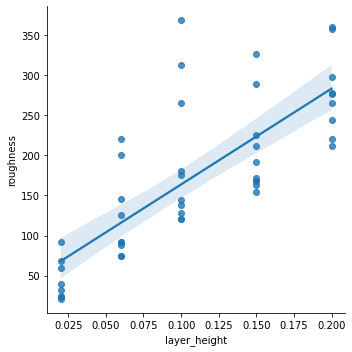

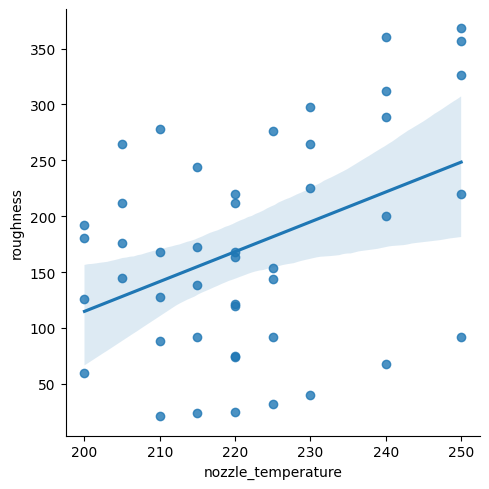

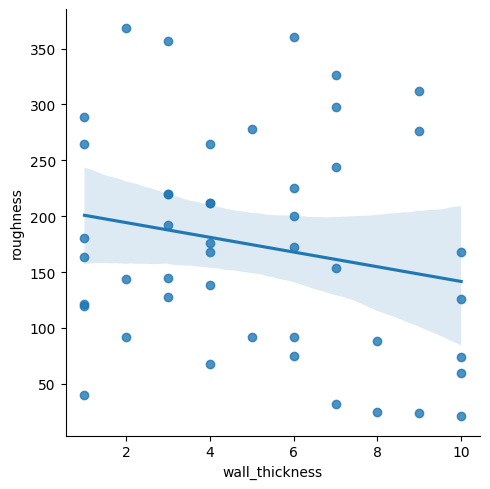

In [12]:
statsObj.targetRelation(roughness_corr)

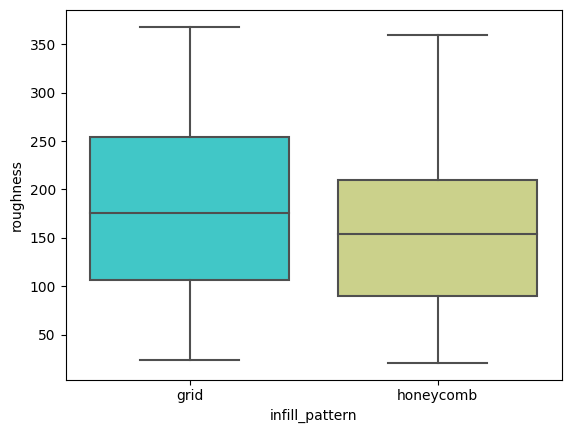

In [13]:
statsObj.plotCategorical(x = 'infill_pattern', y = 'roughness')

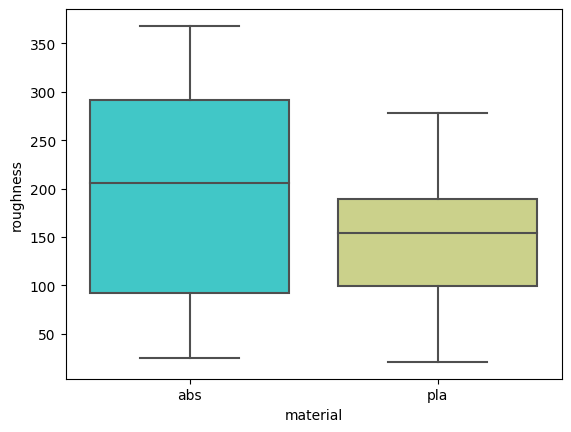

In [14]:
statsObj.plotCategorical(x = 'material', y = 'roughness')

### Target = 'tensile_strength'

In [15]:
tensile_corr = statsObj.correlatedFeatures(target = 'tensile_strength')
tensile_corr

{'target': 'tensile_strength',
 'postive_cor': [('wall_thickness', 0.4299783187945704),
  ('elongation', 0.8374528823899959)],
 'negative_cor': [('nozzle_temperature', -0.41892249542050286),
  ('bed_temperature', -0.27459601199575845),
  ('print_speed', -0.26858492509302073),
  ('fan_speed', -0.2745960119957587)]}

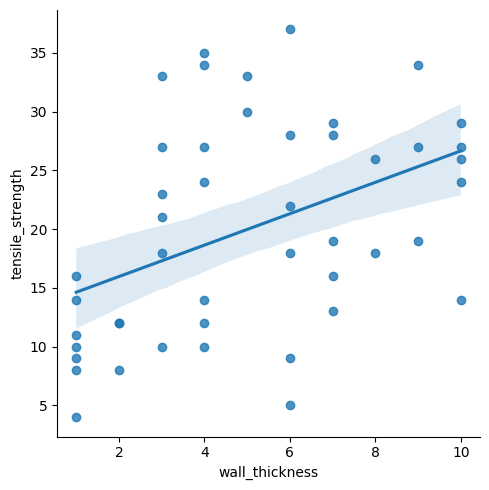

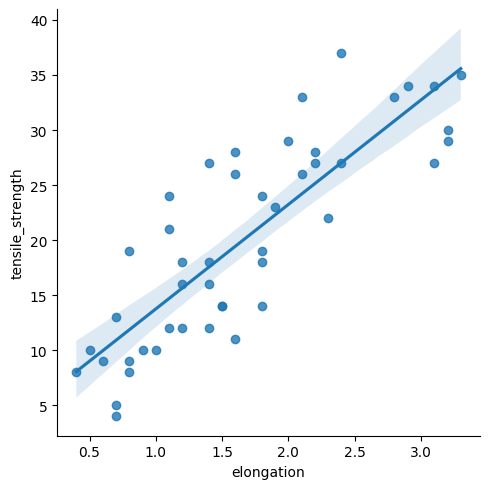

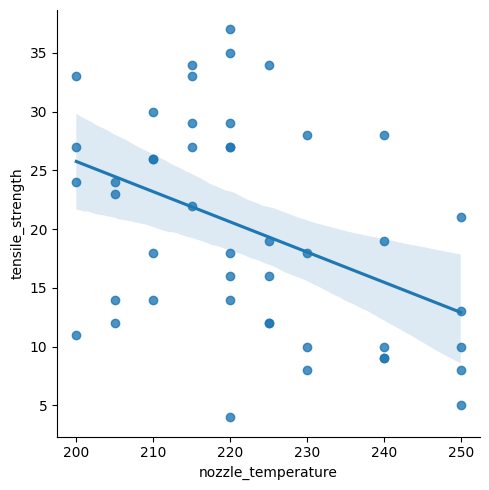

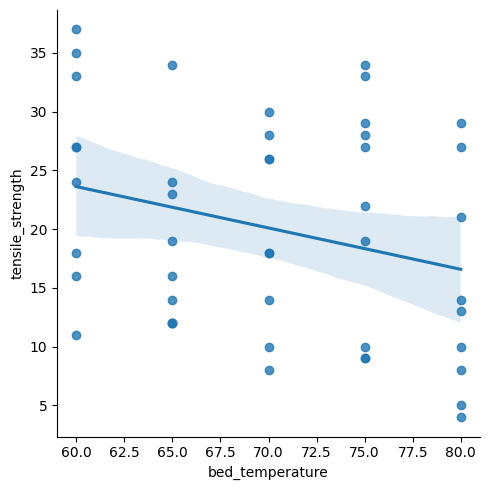

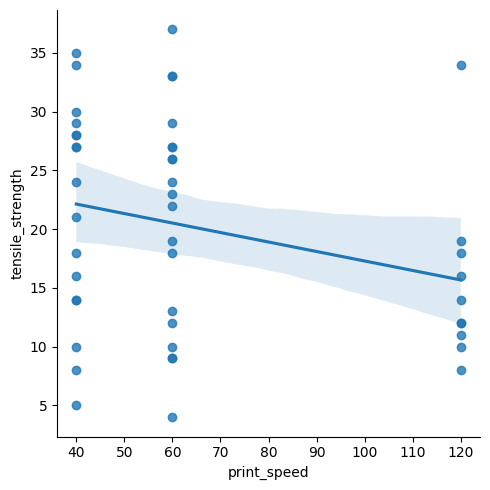

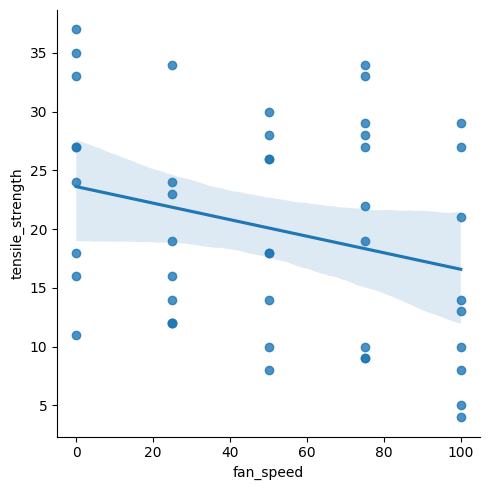

In [16]:
statsObj.targetRelation(tensile_corr)

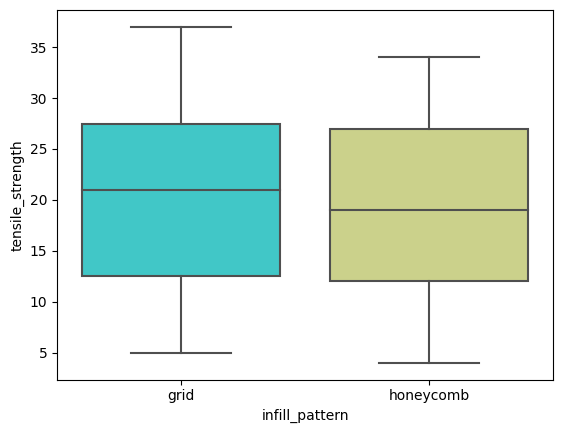

In [17]:
statsObj.plotCategorical(x = 'infill_pattern', y = 'tensile_strength')

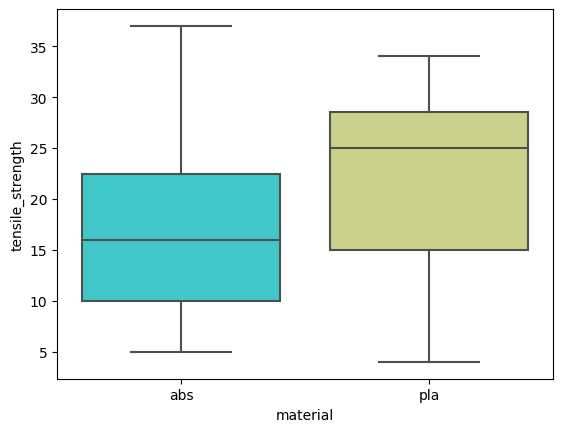

In [18]:
statsObj.plotCategorical(x = 'material', y = 'tensile_strength')

### Target = 'elongation'

In [19]:
elongation_corr = statsObj.correlatedFeatures(target = 'elongation')
elongation_corr

{'target': 'elongation',
 'postive_cor': [('layer_height', 0.49325265653442163),
  ('tensile_strength', 0.8374528823899959)],
 'negative_cor': [('nozzle_temperature', -0.5254619483514119),
  ('bed_temperature', -0.29082737182897916),
  ('print_speed', -0.23063858127718095),
  ('fan_speed', -0.29082737182897994)]}

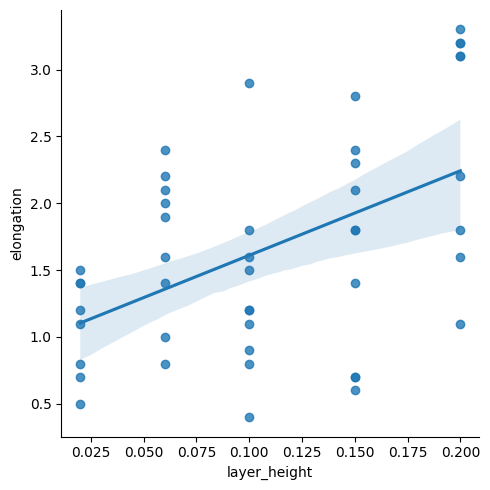

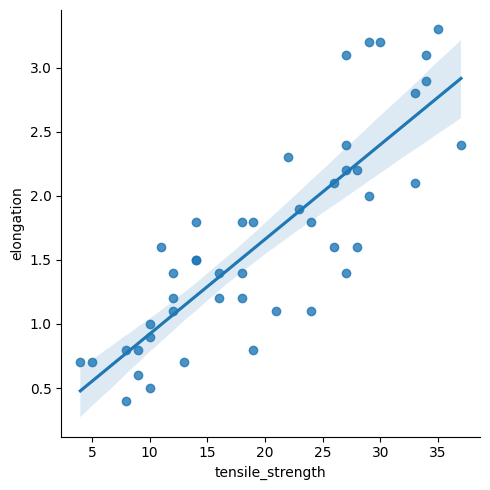

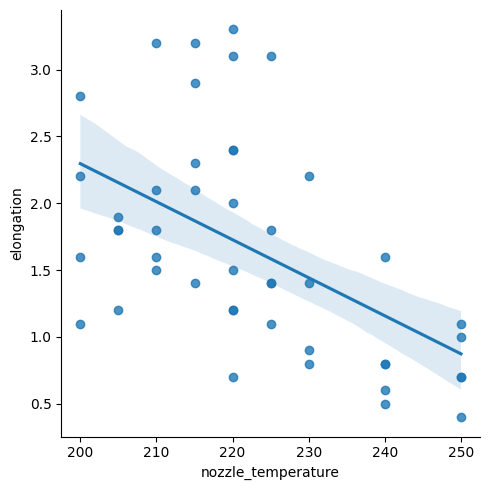

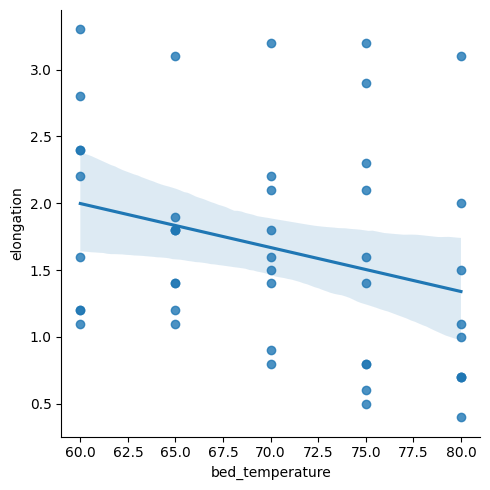

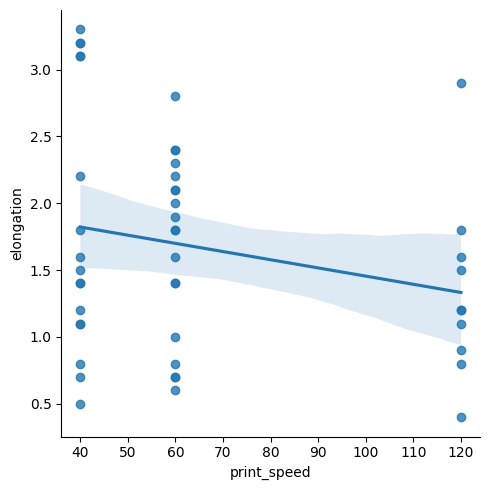

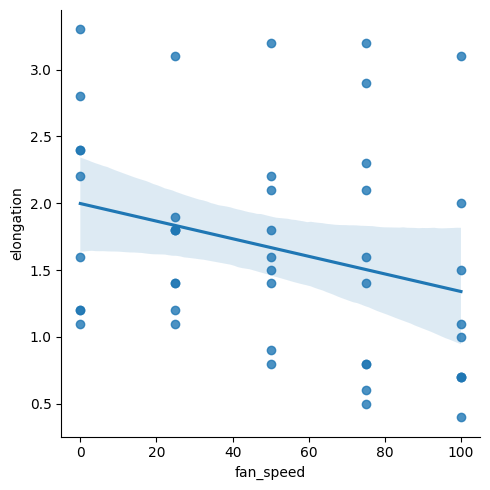

In [20]:
statsObj.targetRelation(elongation_corr)

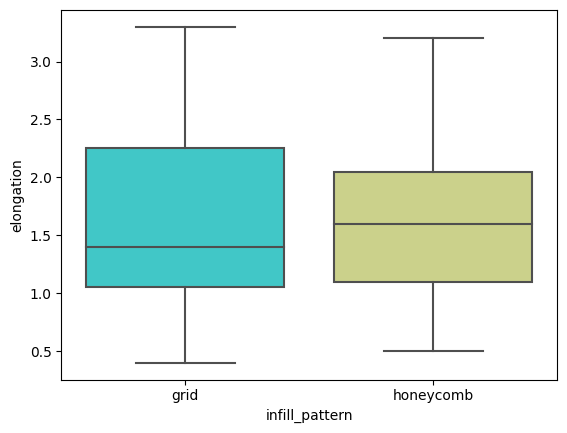

In [21]:
statsObj.plotCategorical(x = 'infill_pattern', y = 'elongation')

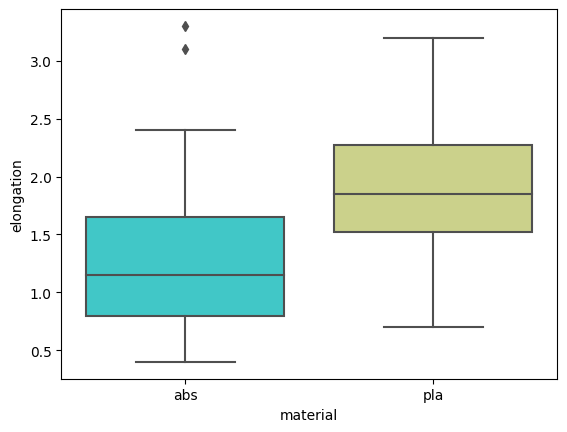

In [22]:
statsObj.plotCategorical(x = 'material', y = 'elongation')

### Pairwise Correlation

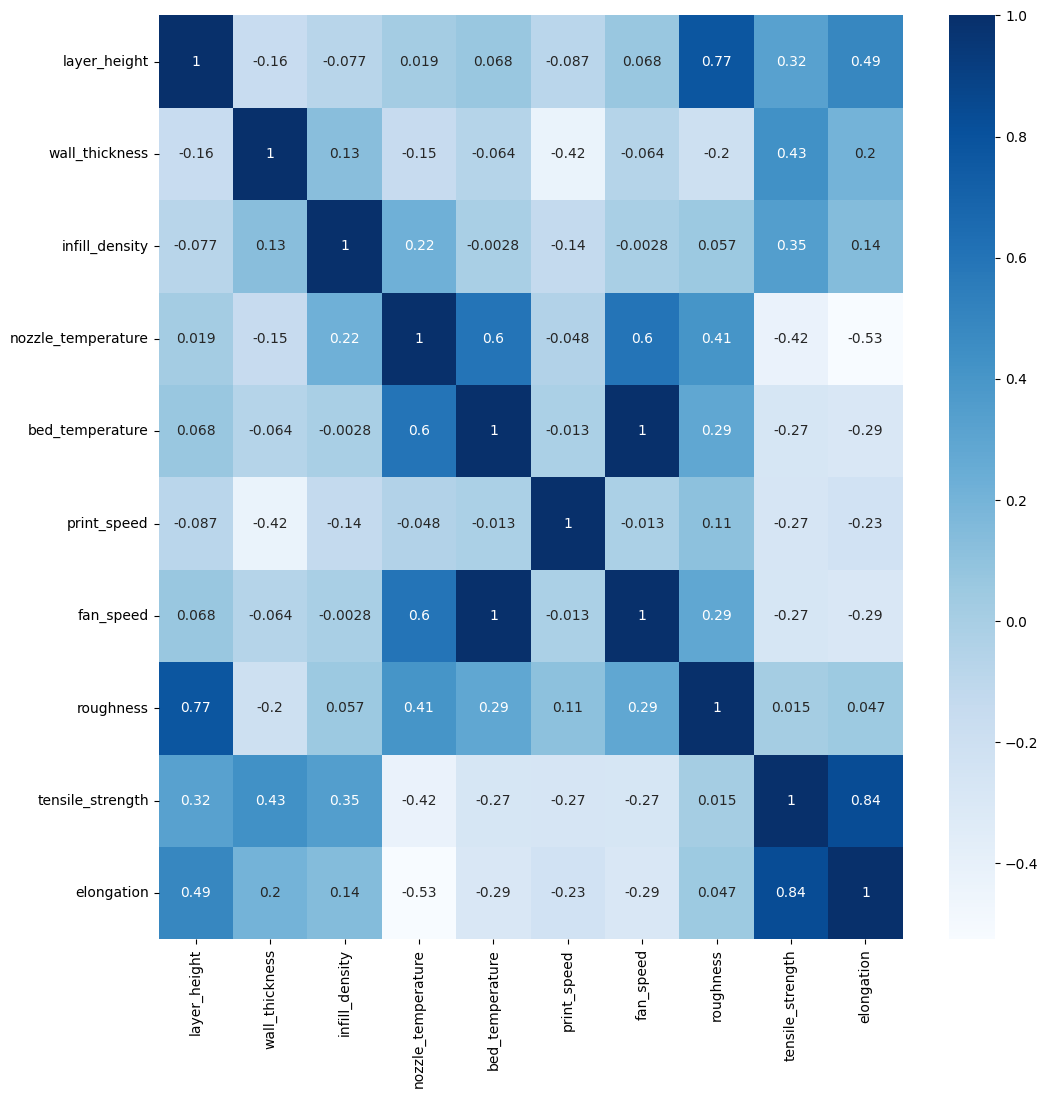

In [23]:
statsObj.pairwiseCorrelation()

### Descriptive Statistical Insights -
A good start is to look at some descriptive statistics -

1. There are in total 46 datapoints
2. There are two categorical variables which need to be one-hot encoded
3. The mean of each term shows that the data needs to be normalized before the model is trained.
4. **Correlation** with the response variable : 
    * 'roughness' : 'layer_height'(0.77) and 'nozzle_temperature'(0.41) are **positively** correlated AND 'wall_thickness' (-0.20) is **negatively** correlated
    * 'tensile_strength' : 'wall_thickness'(0.43) and 'elongation'(0.84) are **positively** correlated 'nozzle_temperature'(-0.42), 'bed_temperature'(-0.27), 'print_speed'(-0.27), 'fan_speed'(-0.27) are **negatively** correlated
    * 'elongation': 'layer_height'(0.49) and 'tensile_strength'(0.84) are **positively** correlated and 'nozzle_temperature'(-0.52), 'bed_temperature'(-0.29), 'print_speed'(-0.23) and 'fan_speed'(-0.29) are **negatively** correlated
5. For **Categorical Variables** (infill_pattern and 'material')-
    * There is a similar distribution of "infill_pattern" and "material" with respect to the target feature "roughness" with a mean value close to 200 resulting in roughness
    * For "tensile_strength" both the values of "infill_pattern" i.e. "grid" and "honeycomb" have similar distributions resulting a mean value of approx 20 for the tensile_strength.
    * 'material' values 'pla' yields a mean of 25 'tensile_strength' and 'abs' yields a mean of '15' in 'tensile_strength'. This shows a distinct variability.
    * Both 'infill_pattern' values 'grid' and 'honeycomb' results in a similar distribution of response variable 'elongation' with a mean value close to 1.5
    * There is a high variability of the response 'elongation' with respect to the type of 'materials'. The mean value of 'elongation' is close to 1 for 'material' type 'abs' and the mean value of 'elongation' is close to 2 for 'material' type 'pla'

# Normality Test
An important decision point whether to use a Parametric or Non-parametric statistical methods depends on how the data is distributed and how a sample is drawn from a given distribution.
* Parametric Statistical Methods : It assumes that the data follows a Gaussian or Normal distribution.
* Non-parametric Statistical Methods : The distribution of data need not be a normal distribution.

#### Quantile-Quantile (QQ plot)
This plot generates its own sample of the idealized distribution that we are comparing with, in this case the Gaussian distribution. The idealized samples are divided into groups, called quantiles. Each data point in the sample is paired with a similar member from the idealized distribution at the same cumulative distribution.

The resulting points are plotted as a scatter plot with the idealized value on the x-axis and the data sample on the y-axis. A perfect match for the distribution will be shown by a line of dots on a 45-degree angle from the bottom left of the plot to the top right. Often a line is drawn on the plot to help make this expectation clear. Deviations by the dots from the line shows a deviation from the expected distribution.

In [24]:
def qqPlot(target, data):
    np.random.seed(101)
    qqplot(data[target], line='s')
    plt.show()

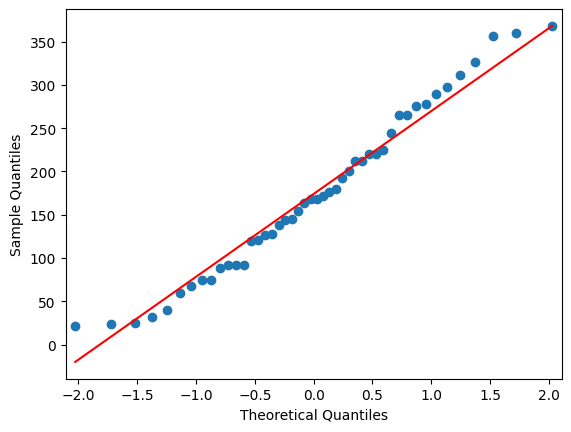

In [25]:
qqPlot('roughness', df)

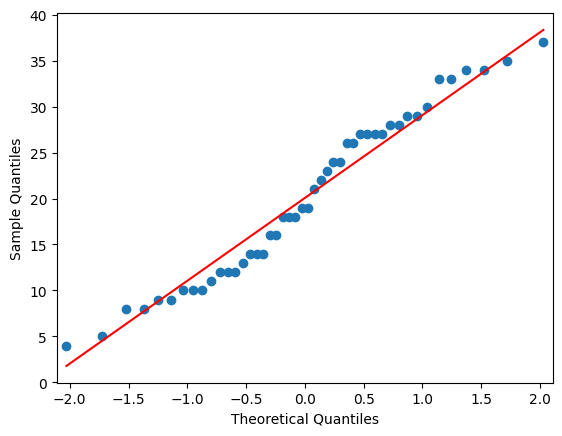

In [26]:
qqPlot('tensile_strength', df)

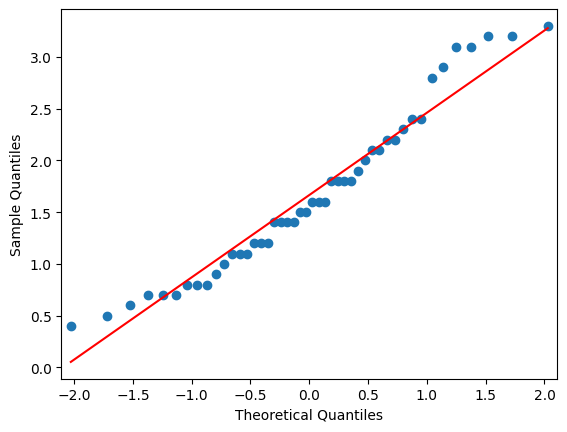

In [27]:
qqPlot('elongation', df)

### Normality Insights - Part 1
* From the QQ plot we can see that "Roughness" is very close to a Gaussian Distribution.
* However 'tensile_strength' and 'elongation' have some deviations from the Gaussian Distribution, but it is not that different.

So, we will test it further using few Statistical Normality Tests.
The following tests assume that the sample was drawn from a Gaussian Distribution. This is called the Null Hypothesis (H0). A threshold level is chosen called alpha, typically 5 % (or 0.05), that is used to interpret the p-value

* p <= alpha : reject H0 (or accept Alternative Hypothesis H1), i.e. not normal
* p > alpha : fail to reject H0, i.e. normal

So, in general we are seeking results with a larger p-value to confirm that our sample was likely drawn from a Gaussian Distribution.

#### Test - 1 : Shapiro-Wilk Test

In [28]:
def shapiroWilkTest(target, data):
    np.random.seed(1)
    stat, p = shapiro(data[target])
    print('Statistics = %.3f, p = %.3f' % (stat, p))
    alpha = 0.05
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')

In [29]:
shapiroWilkTest('roughness', df)

Statistics = 0.967, p = 0.205
Sample looks Gaussian (fail to reject H0)


In [30]:
shapiroWilkTest('tensile_strength', df)

Statistics = 0.955, p = 0.075
Sample looks Gaussian (fail to reject H0)


In [31]:
shapiroWilkTest('elongation', df)

Statistics = 0.947, p = 0.037
Sample does not look Gaussian (reject H0)


#### Test - 2 : D’Agostino’s K^2 Test
It calculates the summary statistics from the data, namely Skewness (3rd Moment) and Kurtosis (4th Moment) to determine if the data distribution departs from the normal distribution.

* Skew is a quantification of how much a distribution is pushed left or right, a measure of asymmetry in the distribution.
* Kurtosis quantifies how much of the distribution is in the tail. It is a simple and commonly used statistical test for normality.

In [32]:
def dAgostinoTest(target, data):
    np.random.seed(1)
    stat, p = normaltest(data[target])
    print('Statistics = %.3f, p = %.3f' % (stat, p))
    alpha = 0.05
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')

In [33]:
dAgostinoTest('roughness', df)

Statistics = 2.784, p = 0.249
Sample looks Gaussian (fail to reject H0)


In [34]:
dAgostinoTest('tensile_strength', df)

Statistics = 9.397, p = 0.009
Sample does not look Gaussian (reject H0)


In [35]:
dAgostinoTest('elongation', df)

Statistics = 3.201, p = 0.202
Sample looks Gaussian (fail to reject H0)


### Normality Insights - Part 2
* In Shapiro-Wilk test : 'roughness' and 'tensile_strength' came out to be drawn from a Gaussian (normal) distribution. However 'elongation' seems to be non-normal.
* In D Agostino's k^2 test : 'roughness' and 'elongation' came out to be drawn from a Gaussian (normal) distribution. However 'tensile_strength' seems to be non-normal.

So, we will definitely consider 'roughness' coming from a normal distribution and will go for a parameteric statistical model.
And, 'tensile_strength' and 'elongation' seem to be soft fail, so we will try out both parametric and non-parametric statistical model.

# Step - 2 : Predictive Analysis

#### Data Loader

In [36]:
# The data preparation for the model -

def createDataLoader(target, cols, data, test_size = 0.3, keep_cols = []):
    if len(keep_cols) > 0:
        features = keep_cols
    else:
        features = []
        for col in cols:
            if col == target:
                continue
            features.append(col)

    print(features)
        
    y = data[target]
    X = data[features]
    
    # Getting dummy encoding for 'infill_pattern' and 'material'
    X = pd.get_dummies(data = X, drop_first=True)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state=101)
    
    data_loader = {'X_train': X_train,
                   'X_test': X_test,
                   'y_train': y_train,
                   'y_test': y_test,
                   'X_features': features,
                   'target': target}
    
    return data_loader

#### Model Interface Class

In [37]:
class Model():
    '''
        It is an abstract base class for all the models. The subclas should implement the following methods -
        1. initialize() : To initialize the model 
        2. train() : To train the model
        3. predict() : To predict using the trained model
    
    '''
    
    @abstractmethod
    def initialize(self):
        raise NotImplementedError
    
    @abstractmethod
    def modelTrain(self):
        raise NotImplementedError
    
    @abstractmethod
    def modelPredict(self):
        raise NotImplementedError

#### Model Implementation Class

In [38]:
class LinearRegressionModel(Model):
    
    def __init__(self):
        super(LinearRegressionModel, self).__init__()
        
    def initialize(self):
        np.random.seed(101)
        self.model = LinearRegression()
        
    def modelTrain(self, data_loader):
        X_train = data_loader['X_train']
        y_train = data_loader['y_train']
        self.model.fit(X_train, y_train)
        return self.model
    
    def modelPredict(self, data_loader):
        X_test = data_loader['X_test']
        predictions = self.model.predict(X_test)
        return predictions

#### Model Saving (Serializing using Pickle)

In [39]:
def saveModel(model, filename):
    pickle.dump(model, open(filename, 'wb'))

#### Fitting the Linear Regression model on "roughness"

In [40]:
data_loader = createDataLoader('roughness', df_columns, df, test_size = 0.3)

['layer_height', 'wall_thickness', 'infill_density', 'infill_pattern', 'nozzle_temperature', 'bed_temperature', 'print_speed', 'material', 'fan_speed', 'tensile_strength', 'elongation']


In [41]:
lm_obj = LinearRegressionModel()
lm_obj.initialize()
lm_roughness = lm_obj.modelTrain(data_loader)
preds_roughness = lm_obj.modelPredict(data_loader)

#### Evaluating the Linear Regression Model on "roughness"
* MAE is the easiest to understand, because it's the average error.
* MSE is more popular than MAE, because MSE "punishes" larger errors, which tends to be useful in the real world.
* RMSE is even more popular than MSE, because RMSE is interpretable in the "y" units.
* R-squared : (coefficient of determination) regression score function. Score close to 1 is the goodness of fit

In [42]:
def evaluateLM(y_test, predictions, plot = True):
    print('MAE:', metrics.mean_absolute_error(y_test, predictions))
    print('MSE:', metrics.mean_squared_error(y_test, predictions))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
    print('R-squared:', r2_score(y_test, predictions))
    if plot:
        plt.rcParams["figure.figsize"] = (15, 8)
        fig = plt.figure()
        ax1 = fig.add_subplot(121)
        ax2 = fig.add_subplot(122)
        ax1.scatter(y_test, predictions)
        ax2.hist((y_test - predictions))
        ax1.set_title("Model Fit Plot")
        ax1.set_xlabel('Y Test')
        ax1.set_ylabel('Predicted Y')
        ax2.set_title("Error Plot")
        plt.show()

MAE: 36.944464480366506
MSE: 2039.4781899144302
RMSE: 45.160582258363654
R-squared: 0.8248963910144327


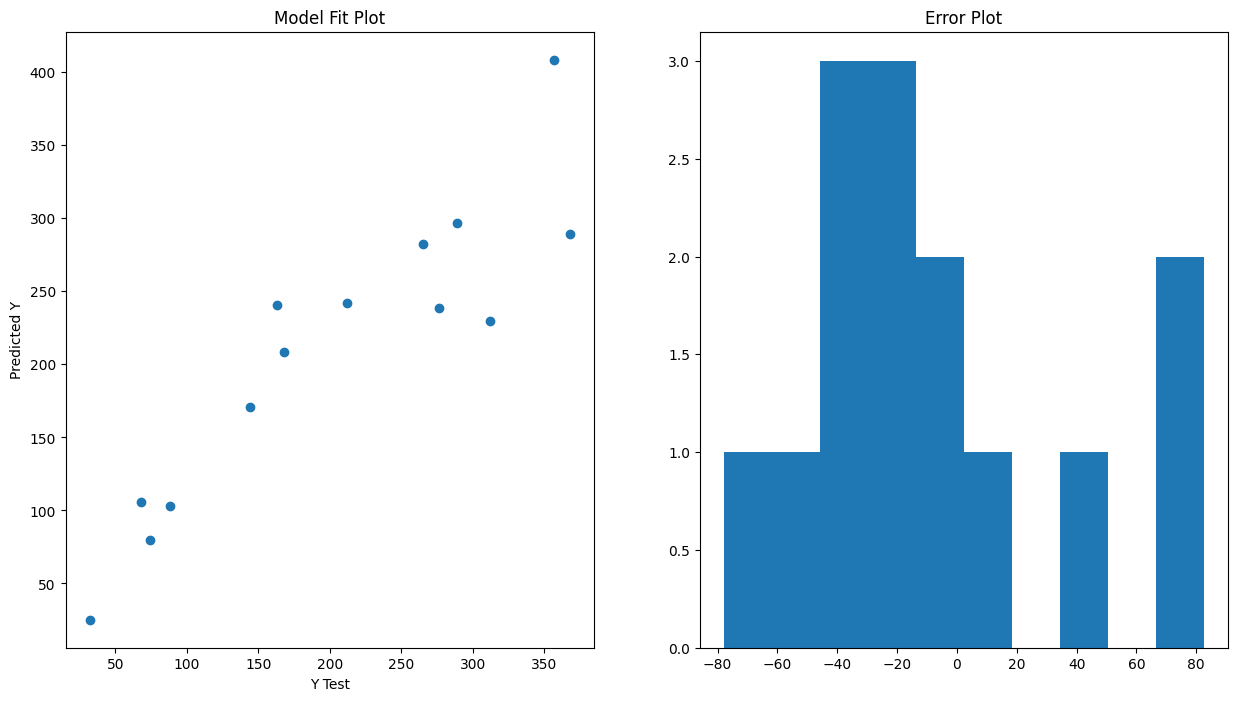

In [43]:
evaluateLM(data_loader['y_test'], preds_roughness)

#### Interpreting the Result

In [44]:
def interpretModel(model):
    coefficients = pd.DataFrame(model.coef_, model.feature_names_in_)
    coefficients.columns = ['Coefficient']
    return coefficients

In [45]:
interpretModel(lm_roughness)

,Coefficient
layer_height,1446.151874
wall_thickness,-1.553483
infill_density,-0.032193
nozzle_temperature,10.715084
bed_temperature,-0.438047
print_speed,0.175992
fan_speed,-2.190234
tensile_strength,1.599054
elongation,-42.617286
infill_pattern_honeycomb,1.305885


#### Saving the Model file

In [46]:
file_name = 'linear_regression_1.pkl'
saveModel(lm_roughness, file_name)

### Feature selection using (significant coefficients) using t-stats and p-values

In [47]:
class LinearRegressionStatsModel(Model):
    
    def __init__(self):
        super(LinearRegressionStatsModel, self).__init__()
        
    def initialize(self):
        np.random.seed(101)
        
    def modelTrain(self, data_loader):
        X_train = data_loader['X_train']
        y_train = data_loader['y_train']
        X_train_new = sm.add_constant(X_train)
        
        est = OLS(y_train, X_train_new)
        self.model = est.fit()
        return self.model
    
    def modelPredict(self, data_loader):
        X_test = data_loader['X_test']
        predictions = self.model.predict(X_test)
        return predictions

In [48]:
lm_stats_obj = LinearRegressionStatsModel()
lm_stats_obj.initialize()
lm_stats_roughness = lm_stats_obj.modelTrain(data_loader)

In [49]:
lm_stats_roughness.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              roughness   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     13.82
Date:                Mon, 08 Aug 2022   Prob (F-statistic):           4.07e-07
Time:                        16:31:16   Log-Likelihood:                -156.00
No. Observations:                  32   AIC:                             334.0
Df Residuals:                      21   BIC:                             350.1
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -0.6619      0.239     -2.766      0.012      -1.160      -0.164
layer_height              1446.1519    167.293      8.644      0.000    1098.246    1794.057
wall_thickness              -1.5535      3.741     -0.415      0.682      -9.333       6.226
infill_density              -0.0322      0.366     -0.088      0.931      -0.793       0.729
nozzle_temperature          10.7151      3.803      2.818      0.010       2.807      18.623
bed_temperature            -38.6252     13.980     -2.763      0.012     -67.699      -9.551
print_speed                  0.1760      0.325      0.542      0.594      -0.500       0.852
fan_speed                    5.4472      1.911      2.850      0.010       1.473       9.421
tensile_strength             1.5991      1.824      0.877      0.391      -2.194       5.392
elongation                 -42.6173     23.097     -1.845      0.079     -90.651       5.417
infill_pattern_honeycomb     1.3059     15.840      0.082      0.935     -31.636      34.248
material_pla               226.0950     84.182      2.686      0.014      51.029     401.161
==============================================================================
Omnibus:                        4.186   Durbin-Watson:                   1.795
Prob(Omnibus):                  0.123   Jarque-Bera (JB):                2.702
Skew:                           0.634   Prob(JB):                        0.259
Kurtosis:                       3.647   Cond. No.                     1.41e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.02e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [50]:
lm_stats_roughness.conf_int()

,0,1
const,-1.159613,-0.164207
layer_height,1098.246322,1794.057426
wall_thickness,-9.333196,6.226229
infill_density,-0.793384,0.728999
nozzle_temperature,2.806675,18.623493
bed_temperature,-67.698926,-9.551392
print_speed,-0.499733,0.851717
fan_speed,1.472977,9.421400
tensile_strength,-2.193656,5.391764
elongation,-90.651111,5.416539


In [51]:
lm_stats_roughness.params

const                         -0.661910
layer_height                1446.151874
wall_thickness                -1.553483
infill_density                -0.032193
nozzle_temperature            10.715084
bed_temperature              -38.625159
print_speed                    0.175992
fan_speed                      5.447189
tensile_strength               1.599054
elongation                   -42.617286
infill_pattern_honeycomb       1.305885
material_pla                 226.095001
dtype: float64

In [52]:
lm_stats_roughness.tvalues

const                      -2.765742
layer_height                8.644408
wall_thickness             -0.415265
infill_density             -0.087952
nozzle_temperature          2.817664
bed_temperature            -2.762814
print_speed                 0.541634
fan_speed                   2.850389
tensile_strength            0.876791
elongation                 -1.845106
infill_pattern_honeycomb    0.082440
material_pla                2.685789
dtype: float64

In [53]:
def selectFeaturesBasedOnTvalues(model, categorical_features = []):
    features = list(model.tvalues[abs(model.tvalues) >= 1.96].index)
    if 'const' in features:
        features.pop(0)
    
    for cat_feature in categorical_features:
        for feature in features:
            if cat_feature in feature:
                features.remove(feature)
                features.append(cat_feature)
    return features

In [54]:
selected_features = selectFeaturesBasedOnTvalues(lm_stats_roughness, ['infill_pattern', 'material'])

In [55]:
print(selected_features)

['layer_height', 'nozzle_temperature', 'bed_temperature', 'fan_speed', 'material']


#### Re-training the model after feauture selection

In [56]:
data_loader_2 = createDataLoader('roughness', df_columns, df, test_size = 0.3, keep_cols = selected_features)

['layer_height', 'nozzle_temperature', 'bed_temperature', 'fan_speed', 'material']


In [57]:
lm_obj_2 = LinearRegressionModel()
lm_obj_2.initialize()
lm_roughness_2 = lm_obj.modelTrain(data_loader_2)
preds_roughness_2 = lm_obj.modelPredict(data_loader_2)

MAE: 34.606584112319624
MSE: 2473.428834888112
RMSE: 49.73357854496408
R-squared: 0.7876386628208821


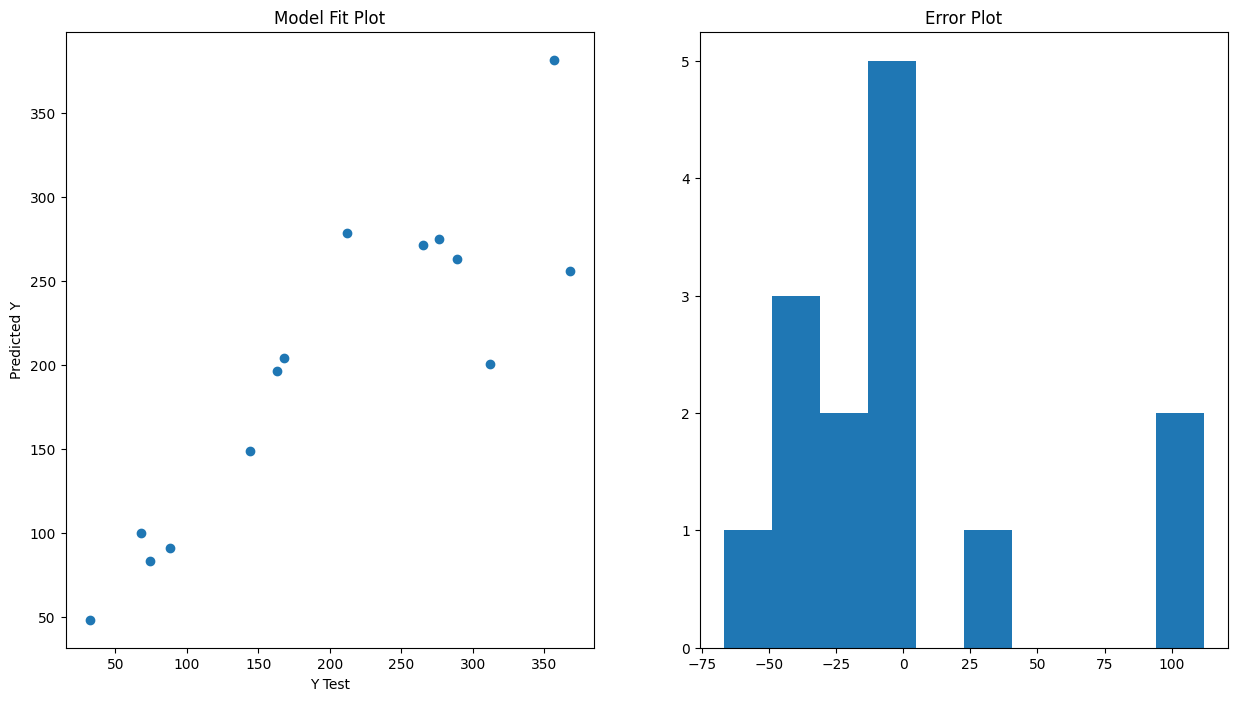

In [58]:
evaluateLM(data_loader_2['y_test'], preds_roughness_2)

#### Interpreting the Result

In [59]:
interpretModel(lm_roughness_2)

,Coefficient
layer_height,1256.501484
nozzle_temperature,11.880566
bed_temperature,-0.487748
fan_speed,-2.438742
material_pla,234.134947


In [60]:
file_name = 'linear_regression_2.pkl'
saveModel(lm_roughness_2, file_name)

#### Check for Multicollinearity

VIF (Variable Inflation Factors) determines the strength of the correlation between the independent variables. It is predicted by taking a variable and regressing it against every other variable. 

VIF = 1 / (1 - R^2)

* VIF starts at 1 and has no upper limit
* VIF = 1, no correlation between the independent variable and the other variables
* VIF exceeding 5 or 10 indicates high multicollinearity between this independent variable and the others

In [61]:
def calc_vif(X):
    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [62]:
vif_1_df = calc_vif(data_loader['X_train'])
vif_1_df

,variables,VIF
0,layer_height,2.136374
1,wall_thickness,2.148199
2,infill_density,1.714370
3,nozzle_temperature,62.825685
4,bed_temperature,19879.128984
5,print_speed,1.955377
6,fan_speed,262.658634
7,tensile_strength,5.235566
8,elongation,6.036313
9,infill_pattern_honeycomb,1.265263


#### Fixing Multicollinearity -
We can clearly see that the following features are highly multicollinear-
* nozzle_temperature
* bed_temperature
* fan_speed
* material_pla

Let's fix this by droping the variables iteratively and checking back the VIFs, we will start the max ones 

One heuristic could be that we can drop of the temperatures. Let's see-

In [63]:
X_dropped = data_loader['X_train'].drop(['bed_temperature', 'elongation', 'fan_speed', 'tensile_strength', 'nozzle_temperature'], axis = 1)
#X_dropped

In [64]:
vif_2_df = calc_vif(X_dropped)
vif_2_df

,variables,VIF
0,layer_height,3.311731
1,wall_thickness,3.614753
2,infill_density,4.860197
3,print_speed,4.112312
4,infill_pattern_honeycomb,1.904379
5,material_pla,2.462700


We don't see any multicolinerity so let's train the model with the updated features

#### Retraining the model after fixing multicolinierity

In [65]:
final_features = list(vif_2_df.variables)

In [66]:
final_features

['layer_height',
 'wall_thickness',
 'infill_density',
 'print_speed',
 'infill_pattern_honeycomb',
 'material_pla']

In [67]:
def cat_features(features, categorical_features):
    for cat_feature in categorical_features:
        for feature in features:
            if cat_feature in feature:
                features.remove(feature)
                features.append(cat_feature)
    return features

In [68]:
final_features = cat_features(final_features, categorical_features = ['infill_pattern', 'material'])

In [69]:
final_dataloader = createDataLoader('roughness', df_columns, df, test_size = 0.3, keep_cols = final_features)

['layer_height', 'wall_thickness', 'infill_density', 'print_speed', 'infill_pattern', 'material']


In [70]:
lm_final_obj = LinearRegressionModel()
lm_final_obj.initialize()
lm_final_roughness = lm_final_obj.modelTrain(final_dataloader)
preds_final_roughness = lm_final_obj.modelPredict(final_dataloader)

MAE: 51.84332052789431
MSE: 4584.0861268399585
RMSE: 67.70587955886813
R-squared: 0.606423825133415


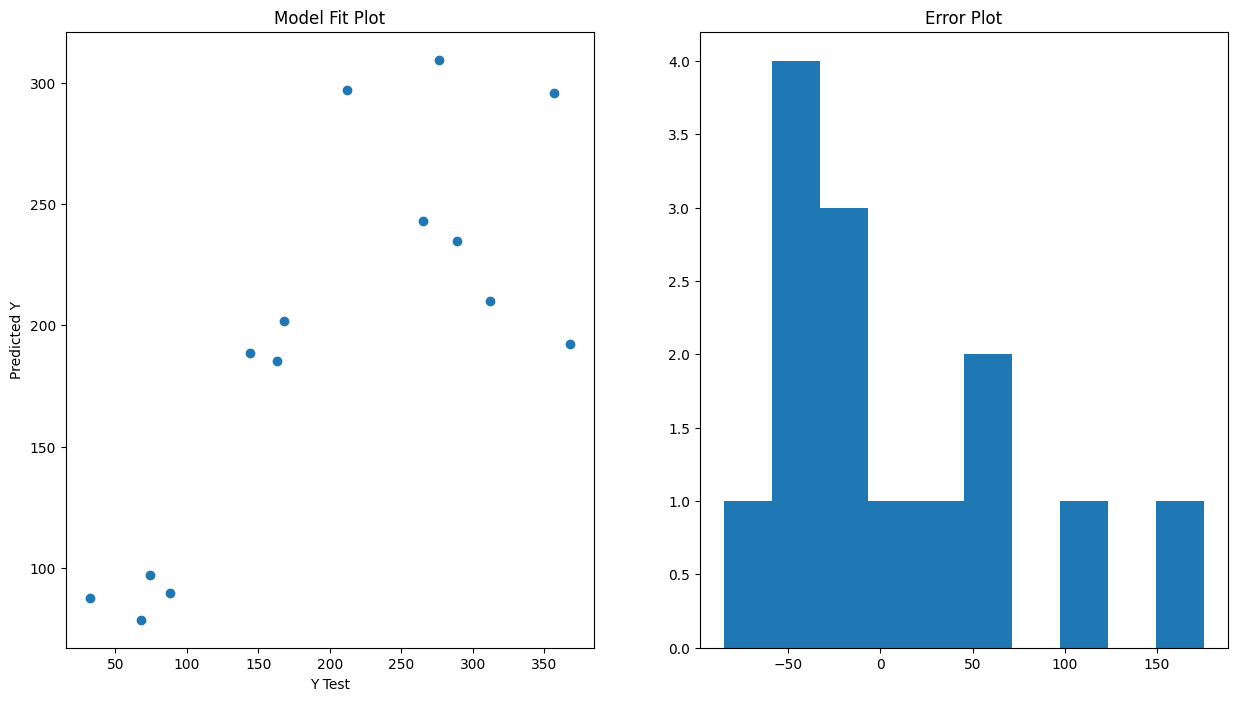

In [71]:
evaluateLM(final_dataloader['y_test'], preds_final_roughness)

In [72]:
coefs_final = interpretModel(lm_final_roughness)

In [73]:
list(coefs_final.index)

['layer_height',
 'wall_thickness',
 'infill_density',
 'print_speed',
 'infill_pattern_honeycomb',
 'material_pla']

In [74]:
file_name = 'linear_regression_final.pkl'
saveModel(lm_final_roughness, file_name)

In [75]:
coefs_final

,Coefficient
layer_height,1219.291701
wall_thickness,1.273681
infill_density,0.246615
print_speed,0.310259
infill_pattern_honeycomb,3.648575
material_pla,-39.282780


In [76]:
lm_final_obj.modelPredict(final_dataloader)

array([309.46738232, 242.90455961, 188.64622989, 201.90196422,
        87.44751328,  97.0980142 , 234.65391387, 295.7105669 ,
        89.61834826, 209.89275762,  78.6941659 , 296.98424834,
       192.39610923, 185.50652821])

In [77]:
final_dataloader['y_test']

38    276
42    265
18    144
34    168
1      32
16     74
30    289
41    357
14     88
20    312
3      68
37    212
21    368
36    163
Name: roughness, dtype: int64

In [78]:
lm_final_roughness.feature_names_in_

array(['layer_height', 'wall_thickness', 'infill_density', 'print_speed',
       'infill_pattern_honeycomb', 'material_pla'], dtype=object)

In [79]:
final_dataloader['X_train'][0:5]

,layer_height,wall_thickness,infill_density,print_speed,infill_pattern_honeycomb,material_pla
7,0.02,9,70,40,0,1
39,0.20,7,30,40,0,0
35,0.15,6,40,60,0,1
40,0.20,6,90,40,1,0
22,0.10,1,50,120,1,1


# Step- 3 : Exploration and Optimization

##### Uniform Distribution of Y "roughness"

In [80]:
def binY(Y, num_bins = 3):
    y_sorted = sorted(Y)
    n = len(Y)
    bins = []
    bin_size = n // 3
    for i in range(0, n, bin_size):
        bins.append(i)
    
    bins[-1] = max(bins[-1], n - 1)
    bins[0] = min(bins[0], -1)
    
    bin_range = []
    for i in range(len(bins) - 1):
        start_bin = bins[i] + 1
        end_bin = bins[i + 1]
        bin_range.append((y_sorted[start_bin], y_sorted[end_bin]))
        
    return bin_range

In [81]:
roughness_range = binY(final_dataloader['y_train'])
roughness_range

[(21, 121), (126, 192), (200, 360)]

In [82]:
def updateYBinsDataLoader(dataloader, y_bins_range):
    y_train_examples = list(dataloader['y_train'])
    y_train_bins = []
    for example in y_train_examples:
        if example >= y_bins_range[0][0] and example <= y_bins_range[0][1]:
            y_train_bins.append('low')
        elif example >= y_bins_range[1][0] and example <= y_bins_range[1][1]:
            y_train_bins.append('medium')
        elif example >= y_bins_range[2][0] and example <= y_bins_range[2][1]:
            y_train_bins.append('high')
            
    dataloader['y_train_bins'] = y_train_bins
    
    return dataloader

In [83]:
dataloader = updateYBinsDataLoader(final_dataloader, roughness_range)

In [84]:
full_df = pd.concat([dataloader['X_train'], dataloader['y_train']], axis = 1)

In [85]:
full_df.reset_index(inplace = True)

In [86]:
full_df = pd.concat([full_df, pd.DataFrame(dataloader['y_train_bins'])], axis=1)

In [87]:
full_df.rename(columns = {0: 'bin'}, inplace=True)

In [88]:
full_df.drop('index', axis = 1, inplace = True)

In [89]:
full_df.head()

,layer_height,wall_thickness,infill_density,print_speed,infill_pattern_honeycomb,material_pla,roughness,bin
0,0.02,9,70,40,0,1,24,low
1,0.20,7,30,40,0,0,298,high
2,0.15,6,40,60,0,1,172,medium
3,0.20,6,90,40,1,0,360,high
4,0.10,1,50,120,1,1,180,medium


In [90]:
def findDistParams(df, bins = ['low', 'medium', 'high'], target = 'roughness'):
    y_map = {}
    for bin in bins:
        x_map = {}
        temp_df = df[df['bin'] == bin]
        
        x_mean = temp_df.mean()
        for k, v in zip(x_mean.keys(), x_mean.values):
            if k == target or k == 'bin':
                continue
            x_map[k] = [v]
            
        x_std = temp_df.std()
        for k, v in zip(x_std.keys(), x_std.values):
            if k == target or k == 'bin':
                continue
            x_map[k].append(v)
            
        x_min = temp_df.min()
        for k, v in zip(x_min.keys(), x_min.values):
            if k == target or k == 'bin':
                continue
            x_map[k].append(v)
            
        x_max = temp_df.max()
        for k, v in zip(x_max.keys(), x_max.values):
            if k == target or k == 'bin':
                continue
            x_map[k].append(v)
        
        y_map[bin] = x_map
        
    return y_map

In [91]:
distribution_stats = findDistParams(full_df, bins = ['low', 'medium', 'high'])

F:\github_repos\polymerize_env\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  import sys
F:\github_repos\polymerize_env\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  del sys.path[0]


In [92]:
distribution_stats
# (mean, stnd, min, max)

{'low': {'layer_height': [0.045454545454545456,
   0.03236159339823562,
   0.02,
   0.1],
  'wall_thickness': [5.363636363636363, 3.640679257301507, 1, 10],
  'infill_density': [57.27272727272727, 29.69542358374741, 10, 90],
  'print_speed': [60.0, 30.983866769659336, 40, 120],
  'infill_pattern_honeycomb': [0.36363636363636365, 0.504524979109513, 0, 1],
  'material_pla': [0.45454545454545453, 0.5222329678670934, 0, 1]},
 'medium': {'layer_height': [0.11200000000000002,
   0.03614784456460256,
   0.06,
   0.15],
  'wall_thickness': [4.5, 2.5495097567963922, 1, 10],
  'infill_density': [54.0, 25.473297566057067, 10, 90],
  'print_speed': [84.0, 30.983866769659336, 60, 120],
  'infill_pattern_honeycomb': [0.5, 0.5270462766947299, 0, 1],
  'material_pla': [0.8, 0.42163702135578396, 0, 1]},
 'high': {'layer_height': [0.15181818181818182,
   0.05582440000898923,
   0.06,
   0.2],
  'wall_thickness': [5.0, 2.0, 1, 7],
  'infill_density': [51.81818181818182, 21.825756260978366, 10, 90],
  'pr

### Number Generator Function (generating inputs)

Draw random samples from a normal (Gaussian) distribution.

The probability density function of the normal distribution, is often called the bell curve because of its characteristic shape (see the example below).

The normal distributions occurs often in nature. For example, it describes the commonly occurring distribution of samples influenced by a large number of tiny, random disturbances, each with its own unique distribution

The probability density for the Gaussian distribution is

p(x) = (1 / sqrt(2*pi*sigma^2)) * exp^(-(x - mu)^2 / 2*sigma^2)

where  is the mean and  the standard deviation. The square of the standard deviation, , is called the variance.

The function has its peak at the mean, and its “spread” increases with the standard deviation (the function reaches 0.607 times its maximum at  and  [2]). This implies that normal is more likely to return samples lying close to the mean, rather than those far away.

In [93]:
bins = ['low', 'medium', 'high']
y_range_map = {}
for rng, bi in zip(roughness_range, bins):
    y_range_map[bi] = rng

y_range_map

{'low': (21, 121), 'medium': (126, 192), 'high': (200, 360)}

In [94]:
def generateInputDistribution(num_points, y_range):
    start = int(y_range_map[y_range][0])
    end = int(y_range_map[y_range][1])
    
    final_distribution = {}
    for variable, metrics in distribution_stats[y_range].items():
        mu = metrics[0]
        sigma = metrics[1]
        s = np.random.normal(mu, sigma, num_points)
        final_distribution[variable] = s
    
    return final_distribution

In [95]:
generateInputDistribution(10, 'high')

{'layer_height': array([0.30292645, 0.18688331, 0.20250503, 0.17994395, 0.18816645,
        0.13399244, 0.10447479, 0.18564583, 0.03915515, 0.19313505]),
 'wall_thickness': array([ 6.05762699,  3.82199893,  5.37739062,  3.48225589,  3.13352557,
         6.91011302,  5.38158864,  8.95751465, 10.21193456,  6.36701777]),
 'infill_density': array([58.42408413, 88.78496556, 14.58156613, 26.51952398, 48.87518112,
        60.34174733, 55.46100172, 55.84507443, 69.44697423, 53.41058191]),
 'print_speed': array([ 71.28248683,  64.06251523,  44.75378765,  38.75236238,
         34.3304097 ,  67.68499573,  53.63639926, 100.77905937,
         61.92508394, 102.99538724]),
 'infill_pattern_honeycomb': array([-0.13748988,  0.46292663, -0.20982923,  0.36382126,  0.881271  ,
         0.28462881,  0.3477039 ,  0.69148973,  1.45081022,  0.05574553]),
 'material_pla': array([-0.01744414,  0.18885958,  0.43781504,  0.12174285,  0.64554949,
         0.88067875, -0.10349033,  1.30349785, -0.20840272,  0.67163

In [96]:
generateInputDistribution(100, 'low')['layer_height']

array([ 0.0579471 ,  0.11289671,  0.0332698 ,  0.0529086 ,  0.06749956,
        0.07895284,  0.04444614,  0.10823385,  0.0129251 ,  0.02144905,
        0.05151019,  0.02173851,  0.00070105,  0.09343046,  0.07656886,
       -0.0238385 ,  0.0775758 ,  0.08403735,  0.01157909,  0.08729047,
       -0.00203655,  0.02946483,  0.04019466,  0.06117609,  0.05815611,
        0.05262234,  0.01777904,  0.09535581,  0.0670177 ,  0.02803642,
        0.02705435,  0.09099825,  0.06622439,  0.01616407,  0.03279609,
        0.07873175, -0.0183821 ,  0.01740076,  0.06878038,  0.00587366,
        0.0974525 ,  0.00934839,  0.00062149,  0.00242463,  0.04679626,
        0.03215214,  0.02049312,  0.04902977,  0.01941474,  0.05365976,
        0.066462  ,  0.05707043,  0.01048877,  0.07465757,  0.05069004,
        0.0724127 ,  0.07703039,  0.03289052,  0.0708039 ,  0.02251167,
        0.06444586, -0.00701485,  0.06738066,  0.04629936, -0.00885739,
        0.05626245,  0.02822295,  0.11398758,  0.05184674,  0.11

### Note : The above generateInputDistribution() 

This function would be used to generate the input space of features which will be used to regress the "Roughness" for which we already have a model trained. You can think of these as partial derivaties and if you sum them up, it gives you the value of the Total Derivatives. Higher the total derivative, higher the final value of roughness. We come to this step where internally the Mean Squared Error Loss function is optimized.

In [97]:
with open('distribution_stats.pkl', 'wb') as file:
    pickle.dump(distribution_stats, file, protocol=pickle.HIGHEST_PROTOCOL)

In [98]:
# # laod a pickle file
# with open("distribution_stats.pkl", "rb") as file:
#     loaded_dict = pickle.load(file)
# # display the dictionary
# print(loaded_dict)

# Inference 

In [99]:
input_space = generateInputDistribution(20, 'high')

In [100]:
input_space

{'layer_height': array([0.14448131, 0.18162021, 0.29156798, 0.20759004, 0.17885927,
        0.15804017, 0.17340458, 0.19701101, 0.17758128, 0.21852211,
        0.21310506, 0.14125872, 0.12587569, 0.17995538, 0.24608135,
        0.091753  , 0.1774319 , 0.14911091, 0.14371346, 0.13965892]),
 'wall_thickness': array([ 8.14466794,  7.16798597,  5.3241726 ,  3.98756916,  6.86645631,
         5.73009125,  4.1500141 ,  4.187774  ,  5.53977196,  1.68907189,
         4.70972066,  4.44640552,  3.87504274,  6.40707117,  3.48466548,
         5.47931535,  4.22682764,  4.21762687,  4.02172888, 10.72894969]),
 'infill_density': array([54.06371437, 33.6807251 , 16.7402777 , 19.53030292, 30.25676813,
        41.27124148, 47.44517086, 74.79530722, 41.31814946, 60.03954204,
        51.15251043, 65.06755399, 62.87371147, 52.49781732, 49.59458721,
        94.77041478, 54.1805188 , 26.85198232, 39.09462921, 15.26719013]),
 'print_speed': array([ 41.20809168,  22.03015521,  80.33623082, 108.74611217,
       

In [101]:
with open("linear_regression_final.pkl", "rb") as file:
    lr_model = pickle.load(file)
print(lr_model)

LinearRegression()


In [105]:
test_df = pd.DataFrame(input_space)

In [106]:
lr_model.predict(test_df)

array([224.12999875, 227.0492633 , 406.60502678, 325.28363789,
       239.38792152, 211.45710893, 241.02500842, 251.11838905,
       250.89010474, 290.04780028, 331.90801274, 217.94262271,
       179.12224628, 314.89064363, 333.32135269, 151.60215969,
       304.82034224, 235.45278182, 215.20323042, 130.43089076])